### Ocean-atmosphere heat fluxes in the Beaufort Sea region 

#### Author: Jonathan Rheinlænder*
#### Date: Aug. 30 2021
#### Affiliation: Nansen Environmental and Remote Sensing Center, Bergen, Norway
*jonathan.rheinlaender@nersc.no

In [1]:
# allow plots to be interactive in the notebook
%matplotlib notebook
import cartopy
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xarray as xr
from datetime import datetime
import matplotlib as mpl
import sys
import os
import cmocean 
import datetime as dt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from pynextsim.projection_info import ProjectionInfo
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.axes_grid1.colorbar import colorbar

/cluster/home/rheinlender/packages/miniconda3/envs/pynextsim/lib/python3.6/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid1.colorbar module was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use matplotlib.colorbar instead.


In [2]:
def make_figure(wi, hi, nrow,ncol):

    fig = plt.figure(figsize=(wi,hi))
    #plt.subplots_adjust(hspace=5, wspace=0.01, top=0.95, bottom=0.1, left=0.075, right=0.925)
    gs = gridspec.GridSpec(nrow,ncol)
    
    return fig, gs 

def prepare_grid(ds):
    
    # Get x-y grid from model
    lons = ds.longitude[:]
    lats = ds.latitude[:]
    x,y=proj.pyproj(lons.values, lats.values) # init grid using x,y coords of grid
    x_extent = [(x,y)[0][0][0], (x,y)[0][0][-1]]
    y_extent = [(x,y)[1][0][0], (x,y)[1][-1][0]]
    ex_lim=1
    x_extent = [(x,y)[0][0][ex_lim], (x,y)[0][0][-ex_lim]]
    y_extent = [(x,y)[1][ex_lim][0], (x,y)[1][-ex_lim][0]]

    grid = dict(
        extent=extent,
        proj=proj,
        x_extent=x_extent,
        y_extent=y_extent,
        )

    return grid

def plot_nextsim(ax, grid, array, clevs, cmap, add_colorbar=True, **cbargs):
    
    cs = ax.contourf(array, zorder=1, extent=[*grid['x_extent'], *grid['y_extent']],
             levels=clevs, cmap=cmap, extend='max')

    ax.add_feature(cartopy.feature.LAND,zorder=1,alpha=1, color="darkgrey")
    ax.coastlines(resolution='50m', linewidth=0.5)
    ax.set_aspect(1)
    ax.gridlines(zorder=2,linewidth=0.5, alpha=0.5,linestyle="--")
    ax.set_extent([-100, -50, 67, 87], ccrs.PlateCarree(central_longitude=300))
    
    # add title inside subplots
#    ax.text(0.03,0.05,dt.datetime.strftime(dto,'%Y-%m-%d'),horizontalalignment='left',
#        transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='None', alpha=0.75))

    # add colorbar 
    if add_colorbar:
        cax = inset_axes(ax,
                    width="5%",  # width = 50% of parent_bbox width
                    height="100%",  # height : 5%
                    loc='lower left',
                    bbox_to_anchor=(-0.1, 0., 1, 1),
                    bbox_transform=ax.transAxes,
                    borderpad=0)

        out = plt.colorbar(cs, cax=cax, **cbargs)
        #cax.yaxis.set_ticks_position('left')


In [3]:
# load data

rootdir = '/cluster/projects/nn9624k/rheinlender/breakup2013/data/wrf-exp/start_20130213_nudging/'
expts = ["expt_01_wrf10/outputs-v11/", "expt_01_wrf10-nodyn/outputs/"]

files = [os.path.join(rootdir, f, 'Moorings.nc') for f in expts]

ds0 = xr.open_dataset(files[0])
ds1 = xr.open_dataset(files[1])

dslist = [ds0, ds1]

time = ds0['time'].time.values.astype('datetime64[ms]').astype('O')

# subset region: Beaufort Sea
x0=0; x1=260
y0=150; y1=410


# Compare heat fluxes for WRF10 and no_motion expts

(67.246994, 68.10054, 79.729576, 77.95747)
(-154.8929, -122.933556, -108.264465, -175.45337)


<IPython.core.display.Javascript object>


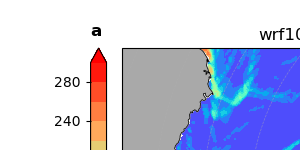

/cluster/home/rheinlender/packages/miniconda3/envs/pynextsim/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/cluster/home/rheinlender/packages/miniconda3/envs/pynextsim/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/cluster/home/rheinlender/packages/miniconda3/envs/pynextsim/lib/python3.6/site-packages/ipykernel_launcher.py:66: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


saving... /cluster/home/rheinlender/projects/aoi_case_study/breakup-paper/figs/heatflx_beaufort-std_no-motion.png


In [5]:
plt.close('all')

labelstr = ["wrf10", 'no_motion']
linestyle_str = [('solid'), ('dashed')]

cell_area = 25*1e6 # m2
weights = ~xr.ufuncs.isnan(ds0['sic'])*cell_area # m2
BSarea = weights.sel(x=slice(x0,x1), y=slice(y0,y1)).sum(dim=("x", "y")).values

extent = [-110, 200, 67, 90]
proj = ProjectionInfo() # default nextsim projection
hacked_proj = proj.crs
hacked_proj._threshold /= 50. # increase resolution
grid = prepare_grid(ds0)

# make Beaufort Box
nlon = ds0.longitude.values
nlat = ds0.latitude.values
lon_corners = (nlon[y1,x0], nlon[y0,x0], nlon[y0,x1],  nlon[y1,x1]) 
lat_corners = (nlat[y1,x0], nlat[y0,x0], nlat[y0,x1], nlat[y1,x1]) 
print(lat_corners)
print(lon_corners)

poly_corners = np.zeros((len(lat_corners), 2), np.float64)
poly_corners[:,0] = lon_corners
poly_corners[:,1] = lat_corners

# pick dates to plot
t1 = '2013-02-20' # start of simulation
t2 = '2013-03-01' # end of simulation

varname = 'hfs'
cbargs = {"label": '(W m$^{-2}$)', "ticklocation": 'left'}
clevs = np.arange(0, 310, 20) # for Heat Fluxes
cmap='rainbow'    

fig, gs = make_figure(5,4, 2, 2)

text = ['a', 'b']

for i, ds in enumerate(dslist):

    if i<=1: # upper plot
        
        # compute heat flux 
        hfs = ds['hfs'].sel(time=slice(t1, t2)).mean(axis=0)
       
        if i==1:
            kw = dict(add_colorbar=False)
            
        else: 
            kw = dict(add_colorbar=True)
 
        ax = plt.subplot(gs[0,i], projection=hacked_proj, extent=grid['extent'])
        plot_nextsim(ax, grid, hfs, clevs, cmap, **kw, **cbargs)  

        if i==1:# add Beaufort Box
            poly = mpatches.Polygon(poly_corners, closed=True, ec='k', ls='--', fill=False, lw=1, zorder=10, transform=ccrs.PlateCarree())
            ax.add_patch(poly)  

        # add titles
        ax.set_title(labelstr[i])
        ax.annotate(text[i], xy=(-0.1, 1.04), xycoords="axes fraction", size=12, weight='bold')

        # lower plot
        ax = plt.subplot(gs[1, 0:])
        
        # calculate average heat fluxes in Beaufort Sea
        hfs_w = ds['hfs'] * weights
        hfs_w = hfs_w.sel(x=slice(x0,x1), y=slice(y0,y1)) 
        hfs_wsum = hfs_w.sum(dim=("x", "y"))
        hfsBS_mean = hfs_wsum/BSarea # divide by total area

        ## Plotting
        color = next(ax._get_lines.prop_cycler)['color']
        l0 = ax.plot(time, hfsBS_mean, label=labelstr[i], color=color)
                     
        # add legend 
        ax.legend(loc='lower left')

        ax.set_ylabel("Heat flux (W m$^{-2}$)")
        ax.grid(linestyle='--', alpha=0.4)
        days = mdates.DayLocator()  # every day
        dtFmt = mdates.DateFormatter('%b %d') # define the formatting 
        ax.xaxis.set_major_formatter(dtFmt)
        ax.xaxis.set_minor_locator(days)
        
        ax.annotate('c', xy=(-0.1, 1.04), xycoords="axes fraction", size=12, weight='bold')
        
# add annotation
#for ax,l in (axlist,text):
#    X = ax.get_position().x0
#    Y = ax.get_position().y1    
 #   fig.text(0, 1, text[i], size=12, weight='bold')

plt.subplots_adjust(wspace=0.0, hspace=0.2, top=0.94, bottom=0.1, left=0.15, right=0.96)
plt.show()   

# save figure
outpath_plots = '/cluster/home/rheinlender/projects/aoi_case_study/breakup-paper/figs/'
figname = os.path.join(outpath_plots,
      '%s%s' % (outpath_plots, 'heatflx_beaufort-std_no-motion.png'))
print("saving...", figname)
fig.savefig(figname, dpi=300, bbox_inches='tight')



#### Comparing heat fluxes for WRF10 and no-motion expts

In WRF10, heat fluxes increase when the breakup starts (19-Feb), but overall pattern is similar to no-motion case. 
Thus variability is not linked to lead formation, but rather synoptic-scale changes in surface heat fluxes. 

In no-motion, since there is no breakup, the gradual ice thickening reduces the transfer of heat from ocean to atmosphere. The main effect of the breakup is to effectively make the ice cover thinner thereby promoting higher ocean-atmosphere heat fluxes. 

